<h2>Import Libraries</h2>

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk 
import re
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


<h2>Reading data</h2>

In [2]:
df = pd.read_csv(r'C:\Users\ASUS\Desktop\dev\dataset\coronavirus-posts-in-reddit-platform\coronavirus_reddit_posts.csv',delimiter=',',encoding='latin-1')
df.head()

,id,subreddit,title,time_created,body,score,num_comments,url
0,fgi2pi,Coronavirus,"Even if COVID-19 is unavoidable, delaying infe...",2020-03-11 02:04:01,NaN,109339,3552,https://thespinoff.co.nz/wp-content/uploads/20...
1,fjcz60,Coronavirus,An Italian hospital ran out of ICU valves. A l...,2020-03-16 09:52:17,NaN,92343,1368,https://twitter.com/michalnaka/status/12393162...
2,fjn7at,Coronavirus,Mitt Romney: Every American adult should immed...,2020-03-16 23:58:19,NaN,71918,3775,https://twitter.com/jmartNYT/status/1239578864...
3,fheqv9,Coronavirus,"As expected, Pornhub offers free Premium acces...",2020-03-12 19:18:23,NaN,70608,1657,https://www.fantacalcio.it/news/attualita/12_0...
4,fk6aqs,Coronavirus,"Italy: Surgeon, anesthesiologist and nurse hav...",2020-03-17 22:36:26,NaN,69634,1495,https://torino.repubblica.it/cronaca/2020/03/1...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9369 entries, 0 to 9368
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            9369 non-null   object
 1   subreddit     9369 non-null   object
 2   title         9369 non-null   object
 3   time_created  9369 non-null   object
 4   body          3146 non-null   object
 5   score         9369 non-null   int64 
 6   num_comments  9369 non-null   int64 
 7   url           9369 non-null   object
dtypes: int64(2), object(6)
memory usage: 585.7+ KB


In [4]:
df.duplicated().sum()

0

In [5]:
df.isnull().sum(axis=0)

id                 0
subreddit          0
title              0
time_created       0
body            6223
score              0
num_comments       0
url                0
dtype: int64

In [6]:
df['subreddit'].value_counts(dropna=False)

CoronaVirus_2019_nCoV    1000
CoronavirusFOS           1000
China_Flu                 999
CanadaCoronavirus         999
nCoV                      998
CoronavirusUK             998
CoronavirusUS             992
Coronavirus               957
COVID19                   822
COVID19_support           604
Name: subreddit, dtype: int64

In [7]:
df['body'].value_counts(dropna=False)

NaN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [8]:
df1 = pd.read_csv(r'C:\Users\ASUS\Desktop\dev\dataset\coronavirus-posts-in-reddit-platform\coronavirus_reddit_clean_comments.csv',delimiter=',',encoding='latin-1')
df1.head()

,id,comment
0,fgi2pi,"everybody i talk area "" whatever "" camp , infu..."
1,fgi2pi,"people going get - avoid , helps tremendously ..."
2,fgi2pi,"i ' feeling hot today . i weird dry cough , li..."
3,fgi2pi,see rest article infectious disease expert [ d...
4,fgi2pi,"considering number icu beds , flatten peak sav..."


In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589022 entries, 0 to 589021
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       589022 non-null  object
 1   comment  587402 non-null  object
dtypes: object(2)
memory usage: 9.0+ MB


In [10]:
df1.duplicated().sum()

5033

In [11]:
df1.drop_duplicates(keep='first').shape

(583989, 2)

In [12]:
df1.isnull().sum(axis=0)

id            0
comment    1620
dtype: int64

In [60]:
df2 = pd.read_csv(r'C:\Users\ASUS\Desktop\dev\dataset\coronavirus-posts-in-reddit-platform\coronavirus_reddit_raw_comments.csv',delimiter=',',encoding='latin-1')
df2.head()

,id,comment
0,fgi2pi,Welcome to r/Coronavirus! We have a very speci...
1,fgi2pi,Everybody I talk to about this in my area is i...
2,fgi2pi,People are going to get it - but if you can av...
3,fgi2pi,I wasn't feeling too hot today. I have this we...
4,fgi2pi,See the rest of the article by infectious dise...


In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605993 entries, 0 to 605992
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       605993 non-null  object
 1   comment  605993 non-null  object
dtypes: object(2)
memory usage: 9.2+ MB


In [15]:
df2.duplicated().sum()

15774

In [16]:
df2.drop_duplicates(keep='first').shape

(590219, 2)

In [17]:
df2.isnull().sum(axis=0)

id         0
comment    0
dtype: int64

<h2>Data Preprocessing </h2>

In [29]:
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()
en_stop = set(nltk.corpus.stopwords.words('english'))

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Removing punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Lowercase
    sentence = sentence.lower() 
    
    # Removing StopWords
    sentence = ' '.join(word for word in sentence.split() if word not in STOPWORDS)
    
    # Stemming
    tokens = sentence .split()
    tokens = [stemmer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in en_stop]
    sentence = ' '.join(tokens)
    
    return sentence


In [30]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [61]:
df2['comment'] = df2['comment'].apply(preprocess_text)


In [36]:
df2.head(5)

,id,comment
0,fgi2pi,welcome coronavirus specific set rule http www...
1,fgi2pi,everybody talk area whatever camp infuriates y...
2,fgi2pi,people going get avoid help tremendously aweso...
3,fgi2pi,feeling hot today weird dry cough little slugg...
4,fgi2pi,see rest article infectious disease expert dr ...


In [109]:
df['title'] = df['title'].apply(preprocess_text)
df['title'].head()

0    even covid unavoidable delaying infection flat...
1    italian hospital ran icu valve local biz broug...
2    mitt romney every american adult immediately r...
3    expected pornhub offer free premium access ita...
4    italy surgeon anesthesiologist nurse risked in...
Name: title, dtype: object

<h2>Task 1 : Sentiment analysis</h2>

<H3>Sentiment analysis using textblob </H3>

In [37]:
!pip install -U textblob

In [38]:
!python -m textblob.download_corpora

Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [42]:
df2['comment'][0]

'welcome coronavirus specific set rule http www reddit com coronavirus rule highlight civil personal attack accusation allowed repeated offence may lead ban avoid topic political discussion comment must related ongoing coronavirus outbreak comment focused politician rather public policy locked removed discretion repeat offender may banned please use reliable source unverified twitter youtube account facebook page general unverified personal account acceptable general question prepping info kept daily discussion thread giving soliciting medical advice includes verified health medical professional feeling anxious depressed overwhelmed please see list support resource http www reddit com coronavirus wiki support bot action performed automatically please contact moderator subreddit message compose coronavirus question concern'

In [43]:
text_blob_object = TextBlob(df2['comment'][0])
print(text_blob_object.sentiment.polarity)

0.05666666666666668


In [44]:
text_blob_object = TextBlob(df2['comment'][0])
print(text_blob_object.sentiment.subjectivity)

0.2927777777777777


In [62]:
def find_pol(review):
    return TextBlob(review).sentiment.polarity

df2['Sentiment_Polarity'] = df2['comment'].apply(find_pol)
df2.head()

,id,comment,Sentiment_Polarity
0,fgi2pi,welcome coronavirus specific set rule http www...,0.056667
1,fgi2pi,everybody talk area whatever camp infuriates y...,0.000000
2,fgi2pi,people going get avoid help tremendously aweso...,0.333333
3,fgi2pi,feeling hot today weird dry cough little slugg...,-0.079390
4,fgi2pi,see rest article infectious disease expert dr ...,0.000000


In [63]:
def find_sub(review):
    return TextBlob(review).sentiment.subjectivity

df2['Sentiment_Subjectivity'] = df2['comment'].apply(find_sub)
df2.head(10)

,id,comment,Sentiment_Polarity,Sentiment_Subjectivity
0,fgi2pi,welcome coronavirus specific set rule http www...,0.056667,0.292778
1,fgi2pi,everybody talk area whatever camp infuriates y...,0.000000,0.000000
2,fgi2pi,people going get avoid help tremendously aweso...,0.333333,0.666667
3,fgi2pi,feeling hot today weird dry cough little slugg...,-0.079390,0.684226
4,fgi2pi,see rest article infectious disease expert dr ...,0.000000,0.000000


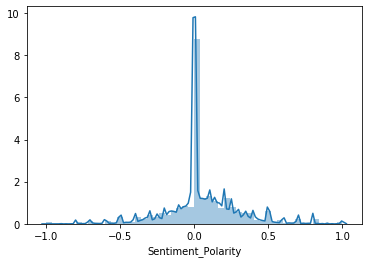

In [65]:
sns.distplot(df2['Sentiment_Polarity'])

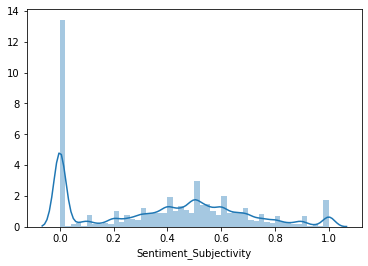

In [67]:
    sns.distplot(df2['Sentiment_Subjectivity'])

<H3>Sentiment analysis using VADER </H3>

In [75]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [76]:
sid.polarity_scores(df2['comment'][0])

{'neg': 0.175, 'neu': 0.622, 'pos': 0.203, 'compound': 0.2023}

In [78]:
df2['scores VADER'] = df2['comment'].apply(lambda review: sid.polarity_scores(review))

df2.head()

,id,comment,Sentiment_Polarity,Sentiment_Subjectivity,scores VADER
0,fgi2pi,welcome coronavirus specific set rule http www...,0.056667,0.292778,"{'neg': 0.175, 'neu': 0.622, 'pos': 0.203, 'co..."
1,fgi2pi,everybody talk area whatever camp infuriates y...,0.000000,0.000000,"{'neg': 0.309, 'neu': 0.591, 'pos': 0.1, 'comp..."
2,fgi2pi,people going get avoid help tremendously aweso...,0.333333,0.666667,"{'neg': 0.097, 'neu': 0.351, 'pos': 0.552, 'co..."
3,fgi2pi,feeling hot today weird dry cough little slugg...,-0.079390,0.684226,"{'neg': 0.233, 'neu': 0.665, 'pos': 0.101, 'co..."
4,fgi2pi,see rest article infectious disease expert dr ...,0.000000,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [81]:
df2['Snetiment VADER']  = df2['scores VADER'].apply(lambda score_dict: score_dict['compound'])

df2.head()

,id,comment,Sentiment_Polarity,Sentiment_Subjectivity,scores VADER,Snetiment VADER
0,fgi2pi,welcome coronavirus specific set rule http www...,0.056667,0.292778,"{'neg': 0.175, 'neu': 0.622, 'pos': 0.203, 'co...",0.2023
1,fgi2pi,everybody talk area whatever camp infuriates y...,0.000000,0.000000,"{'neg': 0.309, 'neu': 0.591, 'pos': 0.1, 'comp...",-0.6808
2,fgi2pi,people going get avoid help tremendously aweso...,0.333333,0.666667,"{'neg': 0.097, 'neu': 0.351, 'pos': 0.552, 'co...",0.8856
3,fgi2pi,feeling hot today weird dry cough little slugg...,-0.079390,0.684226,"{'neg': 0.233, 'neu': 0.665, 'pos': 0.101, 'co...",-0.6947
4,fgi2pi,see rest article infectious disease expert dr ...,0.000000,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


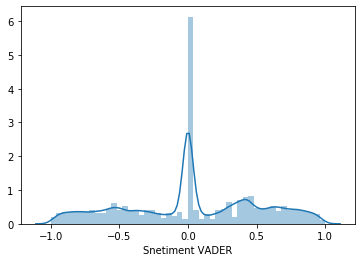

In [82]:
sns.distplot(df2['Snetiment VADER'])

In [84]:
df2['Final score']  = (df2['Snetiment VADER']+df2['Sentiment_Polarity'])/2
df2.head()

,id,comment,Sentiment_Polarity,Sentiment_Subjectivity,scores VADER,Snetiment VADER,Final score
0,fgi2pi,welcome coronavirus specific set rule http www...,0.056667,0.292778,"{'neg': 0.175, 'neu': 0.622, 'pos': 0.203, 'co...",0.2023,0.129483
1,fgi2pi,everybody talk area whatever camp infuriates y...,0.000000,0.000000,"{'neg': 0.309, 'neu': 0.591, 'pos': 0.1, 'comp...",-0.6808,-0.340400
2,fgi2pi,people going get avoid help tremendously aweso...,0.333333,0.666667,"{'neg': 0.097, 'neu': 0.351, 'pos': 0.552, 'co...",0.8856,0.609467
3,fgi2pi,feeling hot today weird dry cough little slugg...,-0.079390,0.684226,"{'neg': 0.233, 'neu': 0.665, 'pos': 0.101, 'co...",-0.6947,-0.387045
4,fgi2pi,see rest article infectious disease expert dr ...,0.000000,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000000


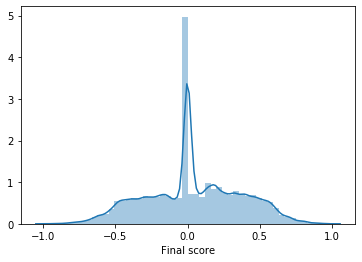

In [85]:
sns.distplot(df2['Final score'])

In [106]:
conditions = [
    (df2['Final score'] < 0),
    (df2['Final score'] > 0) ,
    (df2['Final score'] == 0) 
    ]

# create a list of the values we want to assign for each condition
values = ['-1', '1', '0']

# create a new column and use np.select to assign values to it using our lists as arguments
df2['label'] = np.select(conditions, values)

# display updated DataFrame
df2.head()

,id,comment,Sentiment_Polarity,Sentiment_Subjectivity,scores VADER,Snetiment VADER,Final score,label
0,fgi2pi,welcome coronavirus specific set rule http www...,0.056667,0.292778,"{'neg': 0.175, 'neu': 0.622, 'pos': 0.203, 'co...",0.2023,0.129483,1
1,fgi2pi,everybody talk area whatever camp infuriates y...,0.000000,0.000000,"{'neg': 0.309, 'neu': 0.591, 'pos': 0.1, 'comp...",-0.6808,-0.340400,-1
2,fgi2pi,people going get avoid help tremendously aweso...,0.333333,0.666667,"{'neg': 0.097, 'neu': 0.351, 'pos': 0.552, 'co...",0.8856,0.609467,1
3,fgi2pi,feeling hot today weird dry cough little slugg...,-0.079390,0.684226,"{'neg': 0.233, 'neu': 0.665, 'pos': 0.101, 'co...",-0.6947,-0.387045,-1
4,fgi2pi,see rest article infectious disease expert dr ...,0.000000,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000000,0


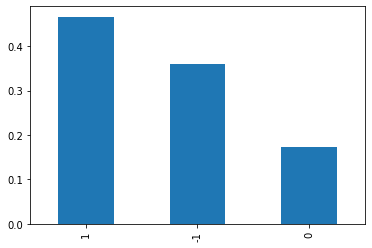

In [107]:
df2['label'].value_counts(normalize=True).plot(kind='bar')

 <h2>Task 2 : Topic Modeling</h2>

<h3>Latent Dirichlet Allocation (LDA) </h3>

The LDA is based upon two general assumptions:


<ul>
<li>Documents that have similar words usually have the same topic
</li>
<li>Documents that have groups of words frequently occurring together usually have the same topic.
</li>
</ul>

In [113]:
#create vocabulary of all the words

In [115]:
count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = count_vect.fit_transform(df['title'].values.astype('U'))

In [116]:
doc_term_matrix

<9369x4954 sparse matrix of type '<class 'numpy.int64'>'
	with 70838 stored elements in Compressed Sparse Row format>

In [132]:
LDA = LatentDirichletAllocation(n_components=2, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=2, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [127]:
#10 words with the highest probability for the first topic

In [133]:
first_topic = LDA.components_[0]
top_topic_words = first_topic.argsort()[-10:]
top_topic_words

array([3160, 3054, 3857, 3279,  708, 1999, 3127, 4409,  995,  959],
      dtype=int64)

In [134]:
for i in top_topic_words:
    print(count_vect.get_feature_names()[i])

people
outbreak
say
positive
china
health
patient
test
covid
coronavirus


In [135]:
#10 words with highest probabilities for all the 3 topics:

In [136]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['people', 'outbreak', 'say', 'positive', 'china', 'health', 'patient', 'test', 'covid', 'coronavirus']


Top 10 words for topic #1:
['school', 'covid', 'confirmed', 'time', 'italy', 'virus', 'people', 'new', 'coronavirus', 'case']




In [137]:
#topic 1 :  coronavirus in china 
#topic 2 : coronavirus in italy

In [138]:
#add a column to the original data fram

In [139]:
topic_values = LDA.transform(doc_term_matrix)
topic_values.shape

(9369, 2)

In [141]:
df['Topic'] = topic_values.argmax(axis=1)
df.head()

,id,subreddit,title,time_created,body,score,num_comments,url,Topic
0,fgi2pi,Coronavirus,even covid unavoidable delaying infection flat...,2020-03-11 02:04:01,NaN,109339,3552,https://thespinoff.co.nz/wp-content/uploads/20...,0
1,fjcz60,Coronavirus,italian hospital ran icu valve local biz broug...,2020-03-16 09:52:17,NaN,92343,1368,https://twitter.com/michalnaka/status/12393162...,1
2,fjn7at,Coronavirus,mitt romney every american adult immediately r...,2020-03-16 23:58:19,NaN,71918,3775,https://twitter.com/jmartNYT/status/1239578864...,1
3,fheqv9,Coronavirus,expected pornhub offer free premium access ita...,2020-03-12 19:18:23,NaN,70608,1657,https://www.fantacalcio.it/news/attualita/12_0...,1
4,fk6aqs,Coronavirus,italy surgeon anesthesiologist nurse risked in...,2020-03-17 22:36:26,NaN,69634,1495,https://torino.repubblica.it/cronaca/2020/03/1...,0


<h3>Task 3 : Predicting the score of the post</h3>

In [142]:
# Use describe to explore the numerical variables 


In [143]:
df.describe()

,score,num_comments,Topic
count,9369.000000,9369.000000,9369.000000
mean,902.288505,87.591419,0.511261
std,4211.429946,294.542419,0.499900
min,0.000000,0.000000,0.000000
25%,13.000000,3.000000,0.000000
50%,36.000000,14.000000,1.000000
75%,180.000000,58.000000,1.000000
max,109339.000000,12840.000000,1.000000


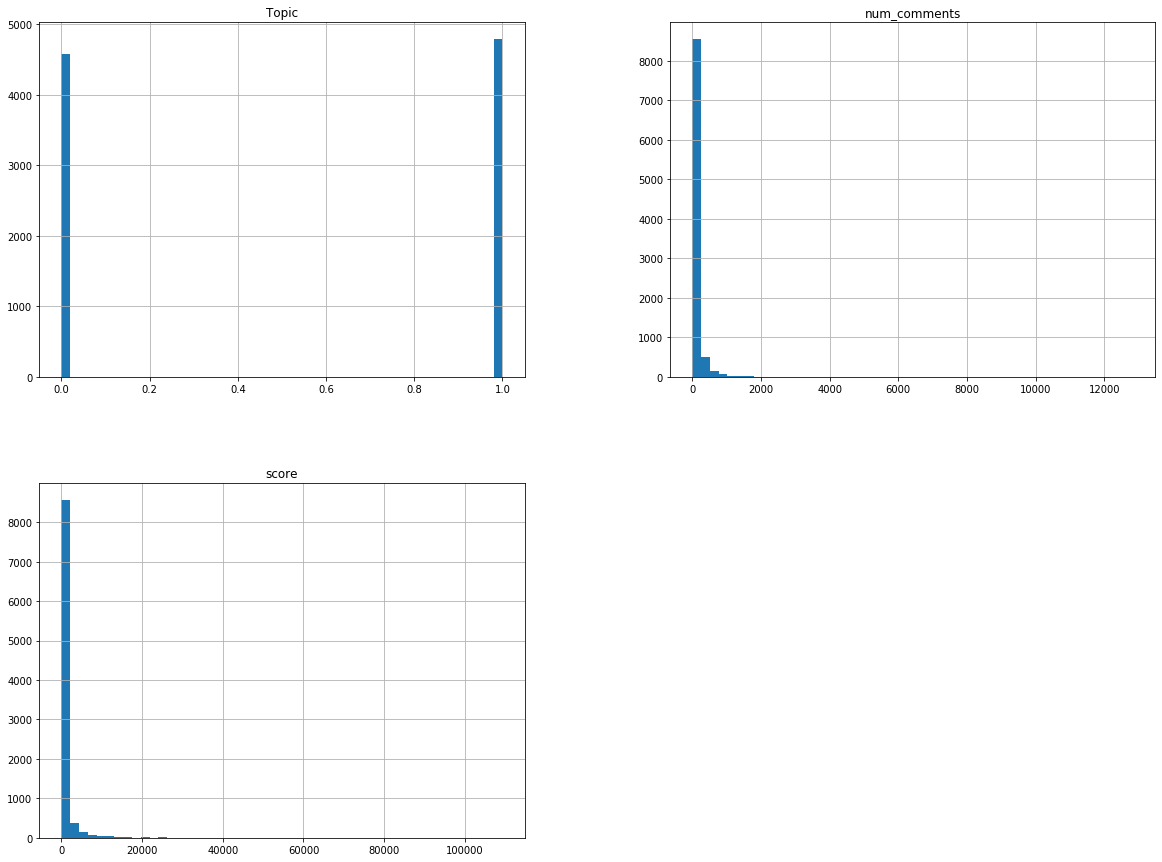

In [144]:
df.hist(bins=50, figsize=(20,15))
plt.show()

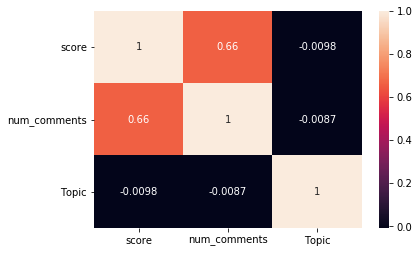

In [147]:
correlation_mat = df.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

In [148]:
#no crrelation betwenn topic and score
#strong correlation between num_comments and scrore

In [200]:
df.drop(['Topic','id','subreddit','title','time_created','body','url'],axis=1,inplace=True)
df.head()

,score,num_comments
0,109339,3552
1,92343,1368
2,71918,3775
3,70608,1657
4,69634,1495


In [211]:
y = df.iloc[:, :-1].values # the  column which contains the num_comments
x = df.iloc[:, 1].values #score

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)

In [213]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

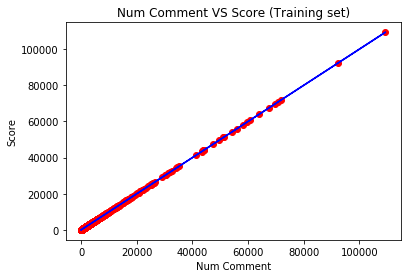

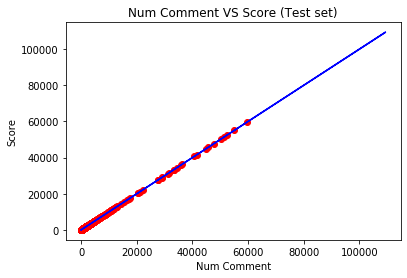

In [215]:
# Visualizing the Training set results
viz_train = plt
viz_train.scatter(X_train, y_train, color='red')
viz_train.plot(X_train, regressor.predict(X_train), color='blue')
viz_train.title('Num Comment VS Score (Training set)')
viz_train.xlabel('Num Comment')
viz_train.ylabel('Score')
viz_train.show()

# Visualizing the Test set results
viz_test = plt
viz_test.scatter(X_test, y_test, color='red')
viz_test.plot(X_train, regressor.predict(X_train), color='blue')
viz_test.title('Num Comment VS Score (Test set)')
viz_test.xlabel('Num Comment')
viz_test.ylabel('Score')
viz_test.show()